In [1]:
from datetime import datetime
import os
import numpy as np
import os.path as osp

%matplotlib inline
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (9, 7)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

/tmp/ipykernel_27790/2266790167.py:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import lsst.geom as geom
import lsst.daf.persistence as dafPersist
from lsst.obs.pfs.utils import getLampElements
import lsst.afw.display as afwDisplay
import pandas as pd
import proxmin as pm
from empca import empca

In [43]:
from pfs.datamodel.pfsConfig import PfsConfig, PfsDesign, FiberStatus, TargetType
from pfs.drp.stella import DetectorMap
from pfs.datamodel import PfsSimpleSpectrum
from pfs.datamodel.target import Target
from pfs.datamodel.masks import MaskHelper
# from pfs.drp.stella.utils import addPfsCursor, showAllSpectraAsImage, showDetectorMap
# import pfs.drp.stella.utils.stability as stability 

In [5]:
# # calibRoot = os.path.join(base, "CALIB-SuNSS-20211108")
# from pfs.drp.stella import ArcLineSet
# base = "/projects/HSC/PFS/Subaru"

# rerun = 'hassans/sunss/w.2022.16c'

# date = '2022-02-22'


# dataDir = os.path.join(base, date)
# calibRoot = os.path.join(base, "CALIB-PFI-20211220")


# butler = dafPersist.Butler("/projects/HSC/PFS/Subaru", calibRoot="/projects/HSC/PFS/Subaru/CALIB-PFI-20211220")

# dataId = dict(visit=72045, arm="r", spectrograph=1)

# #raw = butler.get('raw', dataId, filter=dataId['arm'])
# pfsConfig = butler.get('pfsMerged', dataId)

# # butler.datasetExists("detectorMap_used", dataId)
# # butler.datasetExists("pfsArm", dataId)

# #len(butler.queryMetadata('raw', ['visit', 'taiObs', 'dateObs', 'exptime', 'dataType'], arm='b', dateObs="2021-01-12"))

In [6]:
from pfs.drp.stella import ArcLineSet

base = "/projects/HSC/PFS/Subaru"

# rerun = 'ckj/moon2_270522'
# rerun = 'ckj/moonlc_270522' #subtracted lines/continuum
rerun = 'ckj/moonmerged_170622' #subtracted lines/continuum



dataDir = os.path.join(base, "rerun", rerun)
calibRoot = os.path.join(base, "CALIB-PFI-20211220")
butler = dafPersist.Butler(dataDir, calibRoot=calibRoot)

dataId = dict(visit=72045, arm="r", spectrograph=1)
#raw = butler.get('raw', dataId, filter=dataId['arm'])
pfsConfig = butler.get('pfsConfig', dataId)

# dataId = dict(visit=72045, arm="merged", spectrograph=1)
#raw = butler.get('raw', dataId, filter=dataId['arm'])
merged = butler.get('pfsMerged', dataId)

raw = butler.get('raw', dataId)
md = raw.getMetadata()

zd = md['ZD']
print(zd)

lsst.CameraMapper INFO: Loading exposure registry from /projects/HSC/PFS/Subaru/registry.sqlite3
lsst.CameraMapper INFO: Loading calib registry from /projects/HSC/PFS/Subaru/CALIB-PFI-20211220/calibRegistry.sqlite3
lsst.CameraMapper INFO: Loading calib registry from /projects/HSC/PFS/Subaru/CALIB-PFI-20211220/calibRegistry.sqlite3
41.27639942


In [7]:
merged.flux

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [8]:
from glob import glob
# ids=np.sort(glob('/projects/HSC/PFS/Subaru/rerun/hassans/sunss/2021_2022_full_mergeArms_2022-02-09_07-55-18/DETECTORMAP/*'))
ids=np.sort(glob(osp.join(dataDir,'DETECTORMAP/*')))
idx=[]
for i in ids:
    if i[-7]=='r':
        idx.append(int(i[-13:-8]))
visitList=idx
len(idx), idx, ids

(0, [], array([], dtype=float64))

## See some bandpasses!

<IPython.core.display.Javascript object>


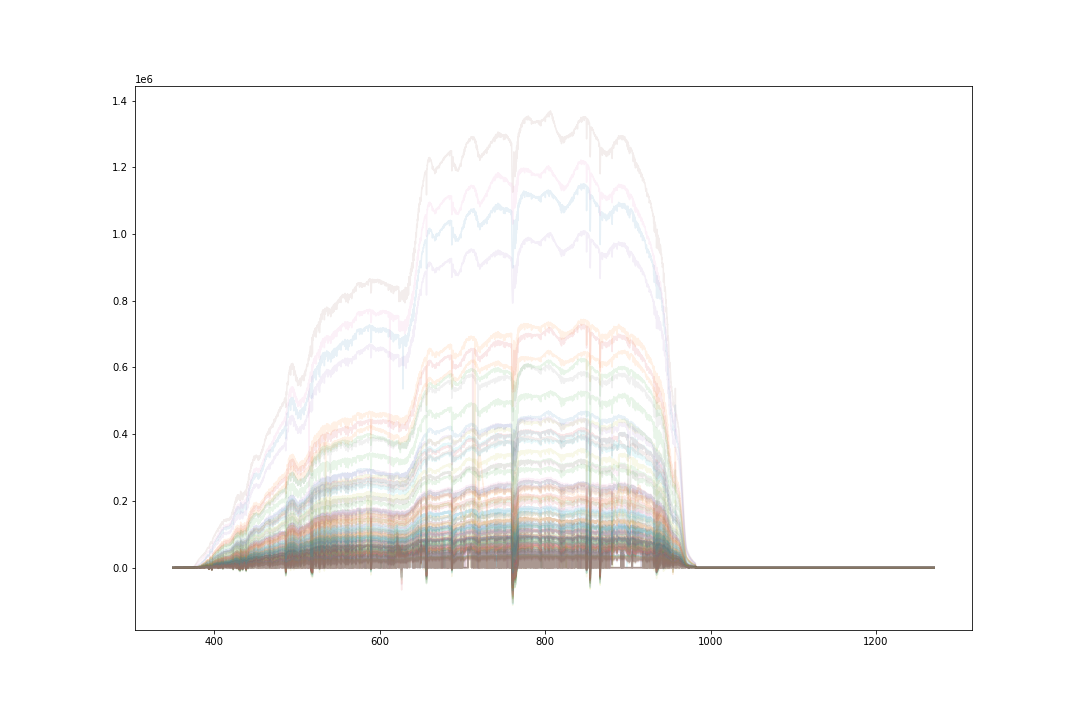

Min 0.0 113 623
Max 556941.25 5 197


/tmp/ipykernel_27790/3977683648.py:46: RuntimeWarning: divide by zero encountered in true_divide
  spec.skyflux = (spec.sky+spec.flux)/np.median(spec.norm, axis=1)[:, np.newaxis ]
/tmp/ipykernel_27790/3977683648.py:46: RuntimeWarning: invalid value encountered in true_divide
  spec.skyflux = (spec.sky+spec.flux)/np.median(spec.norm, axis=1)[:, np.newaxis ]


In [18]:
visit = 72045
# visit = visitList[1]

arm = 'r'
useMerge = True
diffuse = 0
load_lines = 0
norm = 1 #if using merged, no norm
nFibers = 1000
plotraw=0
plotcontinuum=1
verbose = 0

dataId.update(visit=visit, arm=arm)
pfsConfig = butler.get('pfsConfig', dataId)
if load_lines:
    detMap = butler.get("detectorMap_used", dataId)
#diffuse fibers
if diffuse:
    dif = pfsConfig.selectByTargetType(TargetType.SUNSS_DIFFUSE)  
    dif = np.delete(dif, [0, 40])
    fid = pfsConfig.fiberId[dif]
    fid = dif[:nFibers]
else:
    im = pfsConfig.selectByTargetType(TargetType.SUNSS_IMAGING)  
    im = np.delete(im, [23, 83])
    fid = pfsConfig.fiberId[im]
    fid = im[:nFibers]

spec = butler.get("pfsArm", dataId, arm=arm)[fid]

if useMerge:
    spec = butler.get('pfsMerged', dataId)[fid]


if load_lines:
    als = butler.get('arcLines', dataId)
    als.lam = detMap.findWavelength(als.fiberId, als.y)
    df=als.toDataFrame()
    df = df[np.isin(df['fiberId'], fid)]
    wav = np.unique(df.wavelength)
    if len(als.fiberId) == 0:
        print(f"No spots found for {dataId}")   
fig, ax = plt.subplots(figsize=(15,10))
if norm:
    spec.skyflux = (spec.sky+spec.flux)/np.median(spec.norm, axis=1)[:, np.newaxis ]
else:
    spec.skyflux = (spec.sky+spec.flux)
if plotraw:
    ax.plot(spec.wavelength.T, spec.skyflux.T, alpha=1/len(spec.flux));
if plotcontinuum:
    mincont, minid = 1e10, 0
    maxcont, maxid = 0, 0
    ax.plot(spec.wavelength.T, spec.sky.T, alpha=max(1/len(spec.flux), 0.1));
    for i, fl in enumerate(spec.sky):
        f = np.nanmedian(fl)
        if verbose:
            print(i, f)
        if f<mincont:
            mincont = f
            minid = i
        if f>maxcont:
            maxcont = f
            maxid = i
    print('Min', mincont, minid,pfsConfig.fiberId[im[minid]])
    print('Max', maxcont, maxid, pfsConfig.fiberId[im[maxid]])
if nFibers<20:
    ax.plot(spec.wavelength.T, spec.flux.T, alpha=max(1/len(spec.flux), 0.1));
#     ax.set(ylim=(-100, 10000))

In [19]:
spec.norm

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

<IPython.core.display.Javascript object>


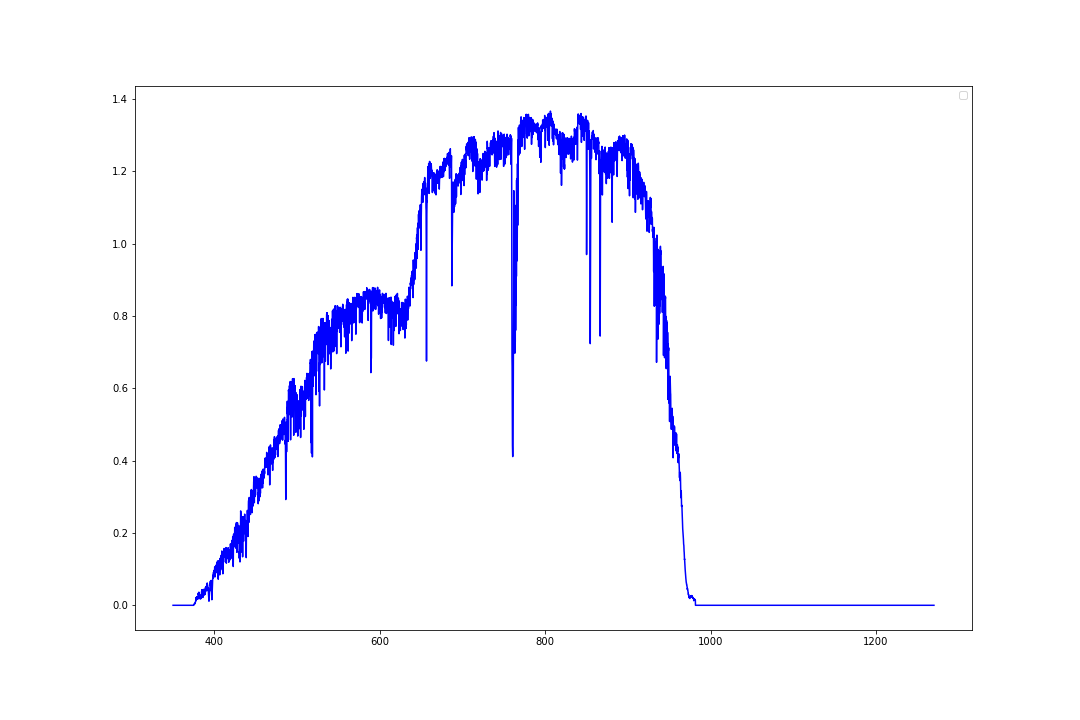

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [20]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(spec.wavelength[maxid].T, spec.skyflux[maxid].T, 'b-')
ax.plot(spec.wavelength[minid].T, spec.skyflux[minid].T, 'r-')
ax.legend()

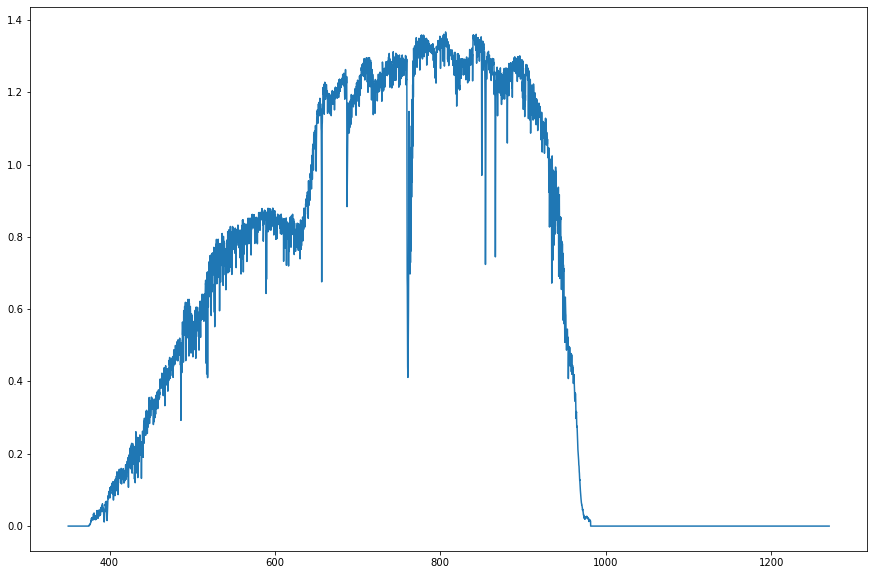

In [35]:
if useMerge:
    ma = spec.skyflux[maxid]

    w = spec.wavelength[maxid]
    lunar=ma
    fig, ax = plt.subplots(figsize=(15,10))
    ax.plot(w, lunar)
else:
    ma = spec.skyflux[maxid]
    mi = spec.skyflux[minid]

    w = spec.wavelength[minid]+spec.wavelength[maxid]
    w = w/2
    lunar=ma-mi
    fig, ax = plt.subplots(figsize=(15,10))
    ax.plot(w, lunar)
# ax.plot(w, ma)

In [23]:
def high_pass_fd(signal, dlam=0.08762323020596341, cutoff=1/2, kT=0.02):
    ft = np.fft.fft(signal)
    freq = np.fft.fftfreq(n=signal.size, d = dlam)
    fmask = freq < 0
    ft[fmask] = 0
    fd = 1-1/(np.exp((freq-cutoff)/kT)+1)
    ft = ft*fd
    signal_filter = np.fft.ifft(ft)
    return signal_filter, ft, fd

In [24]:
def gconv(wav, xs, ys, sig=0.1):
    #Gaussian convolution for Line Spread Function
    ygs = []
    for v in wav:
        f = np.exp(-(v-xs)**2/(2*sig**2))
        ygs.append(np.sum(f * ys/np.sum(f)))
    return np.array(ygs)

In [25]:
water_ranges = [[640, 660],[688, 700],[715,735], [790,835], [890,981.6086615057593]]

0.0 0.3 0.133 0.074 18.432 9.366
0.0 0.35 0.133 0.076 18.128 9.187
0.0 0.4 0.129 0.072 17.848 9.011
0.0 0.45 0.128 0.073 17.601 8.843
0.0 0.5 0.123 0.07 17.359 8.715
0.0 0.55 0.107 0.049 17.16 8.555
0.0 0.6 0.094 0.035 16.975 8.496
0.0 0.65 0.081 0.022 16.801 8.392
0.0 0.7 0.076 0.018 16.661 8.332
0.0 0.75 0.072 0.018 16.539 8.245
0.0 0.8 0.065 0.013 16.428 8.221
0.0 0.9 0.047 -0.006 16.257 8.176
0.0 1.0 0.033 -0.019 16.137 8.12
0.0 1.1 0.027 -0.021 16.098 8.24
0.0 1.2 0.016 -0.027 16.094 8.282
0.0 1.3 -0.001 -0.039 16.128 8.406
0.0 1.4 -0.018 -0.057 16.192 8.539


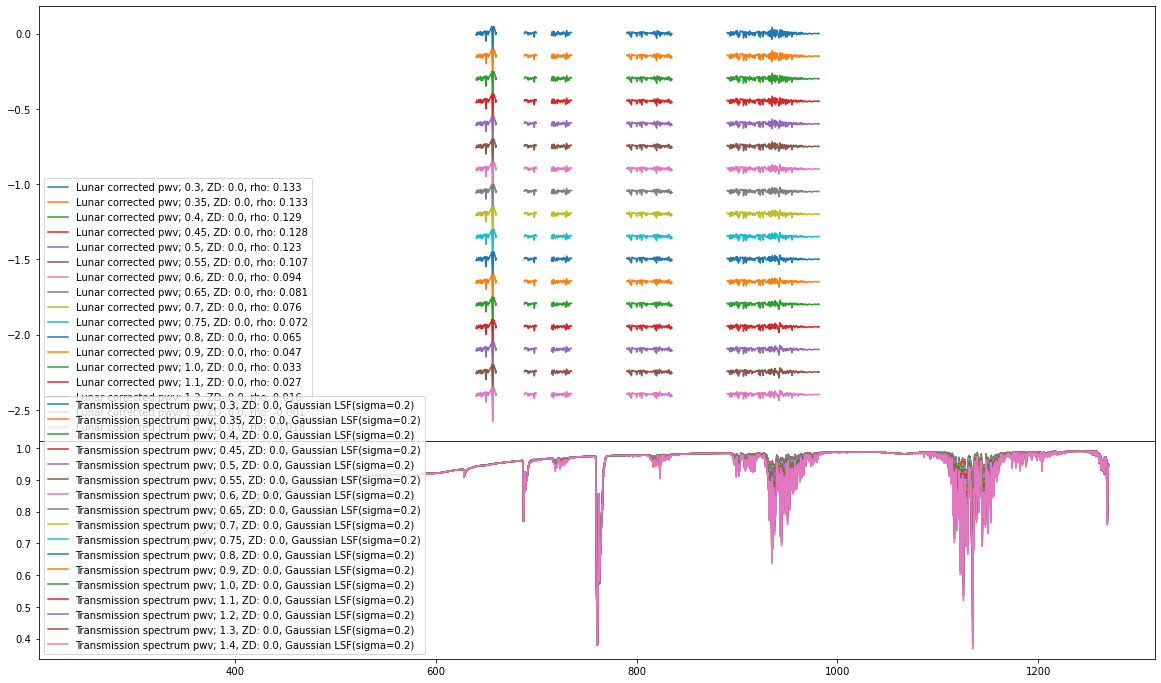

In [26]:
%matplotlib inline

cut, kT = 0.12, 0.02
s = 0.15

zds = [0.0, 5.0, 10.0, 15.0, 20.0, 25, 30.0, 60.0, 75.0]
pwvs = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4]
# pwvs = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.9, 1.0]

zds =[0.0]
# pwvs = [0.0, 0.5, 1.0, 2.0, 3.0, 5.0, 10.0]

sig = 0.2 #0.2 seems good, everything above just changes the scale but nothing else really
k_width = 0.2
rhos = []
rhosmooths = []
stds = []
fts = []
hs = []
ycs = []
smoothLunar = []

for i, r in enumerate(water_ranges):
    if i==0:
        w_mask = np.logical_and(w>r[0], w<r[1])
    else:
        m = np.logical_and(w>r[0], w<r[1])
        w_mask = np.logical_or(w_mask, m)
        
for i, r in enumerate(water_ranges[1:]):
    if i==0:
        clean_mask = np.logical_and(w>r[0], w<r[1])
    else:
        m = np.logical_and(w>r[0], w<r[1])
        clean_mask = np.logical_or(clean_mask, m)

for zd in zds[:3]:
    fig, ax = plt.subplots(2, figsize = (20,12), sharex=True, gridspec_kw={'height_ratios':[2,1]})
    plt.subplots_adjust(hspace=.0)
    k=0
    for k, pwv in enumerate(pwvs):
        if k==0:
            k=0
#             ax[0].plot(w, lunar, label = 'Lunar observed')
        fname = f'transmission_zd{zd}_pwv{pwv}.dat'
        trans = pd.read_table(f'trans/{fname}', header=None, sep='\s+')
        trans.columns = ['wav', 'A']
        mask = np.logical_and(trans['wav']>min(w), trans['wav']<max(w))
        x, y = trans['wav'][mask], trans['A'][mask]
        yc = gconv(w, x, y, sig=sig)
        ycs.append(yc)
        lunarT = lunar/yc
        lunarT, ft, fd = high_pass_fd(lunarT, cutoff = cut, kT = kT)
        lunarT = np.sign(np.real(lunarT))*np.abs(lunarT) #dealing with complex numbers
        hs.append(lunarT)
        lunarsmooth, ysmooth = gconv(w, w, lunarT, sig = k_width), gconv(w, w, yc, sig = k_width) #smooth both with a Gaussian kernel
        lunarsmooth[~w_mask] = np.nan
        ysmooth[~w_mask] = np.nan
        
        smoothLunar.append(lunarsmooth)
        rho = np.corrcoef(lunarT[w_mask], yc[w_mask])[0][1]
        rhosmooth = np.corrcoef(lunarsmooth[w_mask], ysmooth[w_mask])[0][1]
        std = np.std(lunarT[clean_mask])
        stdsmooth = np.std(lunarsmooth[clean_mask])
        ax[0].plot(w, lunarsmooth - s*k , label = f'Lunar corrected pwv; {pwv}, ZD: {zd}, rho: {rho:.3f}')
        ax[1].plot(w, yc, label=f'Transmission spectrum pwv; {pwv}, ZD: {zd}, Gaussian LSF(sigma={sig})')
        
       
        print(zd, pwv, np.round(rho,3), np.round(rhosmooth,3), np.round(std*1000, 3), np.round(stdsmooth*1000, 3))
        rhos.append(rho)
        rhosmooths.append(rhosmooth)
        stds.append(std)
    ax[0].legend(loc='lower left')
    ax[1].legend(loc='lower left')
    xlims = ax[0].get_xlim()
    ax[0].set(xlim = (xlims[0]-100, xlims[1]))

In [27]:
def fit_hp(lunar_spectrum, w, plot=True, cut=0.12, kT=0.02, sep=0.15, sigs = [0.1], smooths = [None],
        pwvs =[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8],
        zds = [0.0], water_ranges = [[640, 660], [688, 700], [715, 735], [790, 835], [890, 981.6086615057593]]):


    rhos = []
    stds = []
    hs = [] #highpass signal
    ycs = []
    configs = []
    for i, r in enumerate(water_ranges):
        if i==0:
            w_mask = np.logical_and(w>r[0], w<r[1])
        else:
            m = np.logical_and(w>r[0], w<r[1])
            w_mask = np.logical_or(w_mask, m)

    for i, r in enumerate(water_ranges[1:]):
        if i==0:
            clean_mask = np.logical_and(w>r[0], w<r[1])
        else:
            m = np.logical_and(w>r[0], w<r[1])
            clean_mask = np.logical_or(clean_mask, m)
    for smooth in smooths:
        for sig in sigs:
            for zd in zds:
                if plot:
                    fig, ax = plt.subplots(2, figsize = (20,12), sharex=True, gridspec_kw={'height_ratios':[2,1]})
                    plt.subplots_adjust(hspace=.0)
                else:
                    fig = None
                for k, pwv in enumerate(pwvs):   
                    configs.append([smooth, sig, zd, pwv])
                    fname = f'transmission_zd{zd}_pwv{pwv}.dat'
                    try: ##should be changed
                        trans = pd.read_table(f'trans/{fname}', header=None, sep='\s+')
                        trans.columns = ['wav', 'A']
                        mask = np.logical_and(trans['wav']>min(w), trans['wav']<max(w))
                        x, y = trans['wav'][mask], trans['A'][mask]
                        yc = gconv(w, x, y, sig=sig)
                        ycs.append(yc)
                        lunarT = lunar/yc
                        lunarT, ft, fd = high_pass_fd(lunarT, cutoff = cut, kT = kT)
                        lunarT = np.sign(np.real(lunarT))*np.abs(lunarT) #dealing with complex numbers
                        if smooth:
                            lunarsmooth, ysmooth = gconv(w, w, lunarT, sig = smooth), gconv(w, w, yc, sig = smooth) #smooth both with a Gaussian kernel
                            lunarsmooth[~w_mask] = np.nan
                            ysmooth[~w_mask] = np.nan
                            hs.append(lunarsmooth)
                            rho = np.corrcoef(lunarsmooth[w_mask], ysmooth[w_mask])[0][1]
                            std = np.std(lunarsmooth[clean_mask])
                            if plot:
                                ax[0].plot(w, lunarsmooth - sep*k , label = f'Lunar corrected pwv; {pwv}, ZD: {zd}, rho: {rho:.3f}')
                        else:
                            hs.append(lunarT)
                            rho = np.corrcoef(lunarT[w_mask], yc[w_mask])[0][1]
                            std = np.std(lunarT[clean_mask])
                            if plot:
                                ax[0].plot(w, lunarT - sep*k , label = f'Lunar corrected pwv; {pwv}, ZD: {zd}, rho: {rho:.3f}')
                        if plot:
                            ax[1].plot(w, yc, label=f'Transmission pwv; {pwv}, ZD: {zd}, Gaussian LSF(sigma={sig})')

                        print('Smooth, sig, ZD, PWV, rho, std')
                        print(smooth, sig, zd, pwv, np.round(rho,3), np.round(std*1000, 3))
                        rhos.append(rho)
                        stds.append(std)
                    except:
                        print(fname+ f' was not found, run libRadtrans at pwv:{pwv} and zd:{zd} and try again')
                        rhos.append(np.nan)
                        stds.append(np.nan)
                if plot:
                    ax[0].legend(loc='lower left')
                    ax[1].legend(loc='lower left')
                    xlims = ax[0].get_xlim()
                    ax[0].set(xlim = (xlims[0]-100, xlims[1]))
                    ax[1].set(xlim = (xlims[0]-100, xlims[1]))
    configs = np.vstack(configs).reshape(len(smooths)*len(sigs), len(zds)*len(pwvs), 4)
    rhos = np.array(rhos).reshape(len(smooths)*len(sigs), len(zds)*len(pwvs))
    stds = np.array(stds).reshape(len(smooths)*len(sigs), len(zds)*len(pwvs))
    return configs, rhos, stds, hs, ycs

In [28]:
def get_zd(butl, zdsg = [0.0, 5.0, 10.0, 20, 30, 40]):
    zdsga = np.array(zdsg)
    raw = butl.get('raw', dataId)
    md = raw.getMetadata()
    zd = md['ZD']
    return zdsg[np.argmin(np.abs(zdsga-zd))], zd

In [29]:
zdsg = [0.0, 5.0, 10.0, 20, 30, 40]
zdsg = np.array(zdsg)
zdsg[np.argmin(np.abs(zdsg-zd))]

0.0

In [30]:
configs, rhos, stds, hs, ycs = fit_hp(lunar, w, plot=False, zds=[get_zd(butler)[0]], sigs = [0.1, 0.05, 0.02])

Smooth, sig, ZD, PWV, rho, std
None 0.1 40 0.3 0.103 20.0
Smooth, sig, ZD, PWV, rho, std
None 0.1 40 0.4 0.039 19.104
Smooth, sig, ZD, PWV, rho, std
None 0.1 40 0.5 -0.04 18.853
Smooth, sig, ZD, PWV, rho, std
None 0.1 40 0.6 -0.091 19.219
Smooth, sig, ZD, PWV, rho, std
None 0.1 40 0.7 -0.153 19.971
Smooth, sig, ZD, PWV, rho, std
None 0.1 40 0.8 -0.19 21.149
Smooth, sig, ZD, PWV, rho, std
None 0.1 40 0.9 -0.235 22.529
Smooth, sig, ZD, PWV, rho, std
None 0.1 40 1.0 -0.264 24.143
Smooth, sig, ZD, PWV, rho, std
None 0.1 40 1.1 -0.308 25.853
Smooth, sig, ZD, PWV, rho, std
None 0.1 40 1.2 -0.339 27.685
Smooth, sig, ZD, PWV, rho, std
None 0.1 40 1.3 -0.361 29.595
Smooth, sig, ZD, PWV, rho, std
None 0.1 40 1.4 -0.377 31.577
Smooth, sig, ZD, PWV, rho, std
None 0.1 40 1.5 -0.4 33.574
Smooth, sig, ZD, PWV, rho, std
None 0.1 40 1.6 -0.412 35.633
Smooth, sig, ZD, PWV, rho, std
None 0.1 40 1.7 -0.434 37.684
Smooth, sig, ZD, PWV, rho, std
None 0.1 40 1.8 -0.443 39.787
Smooth, sig, ZD, PWV, rho, std
N

(0.018852726240540654, 2)

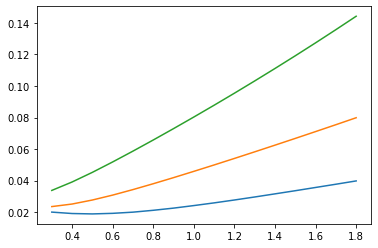

In [31]:
zdsr, pwvsr = np.unique(configs[0][:,2]), np.unique(configs[0][:,3])
plt.plot(pwvsr, stds.T)
stds[0][np.argmin(stds[0])], np.argmin(stds[0])


In [33]:
minconfig = configs[0][np.argmin(stds)]
minconfig

array([None, 0.1, 40, 0.5], dtype=object)

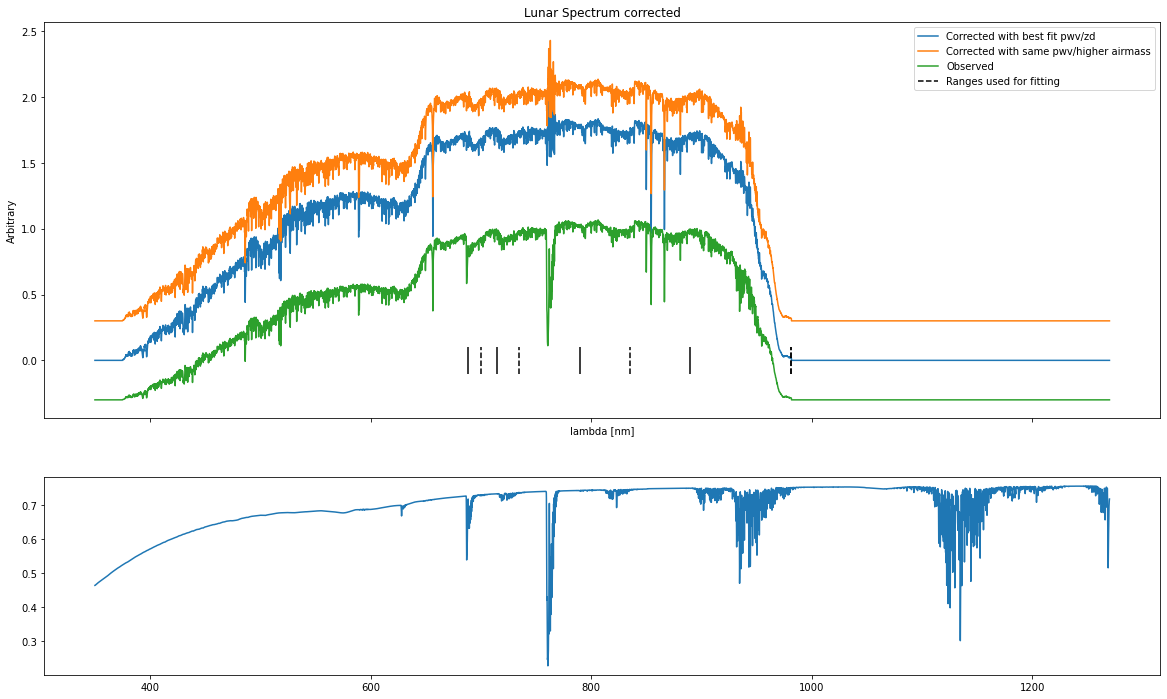

In [37]:
fname = f'transmission_zd{40}_pwv{0.8}.dat'
trans = pd.read_table(f'trans/{fname}', header=None, sep='\s+')
trans.columns = ['wav', 'A']
mask = np.logical_and(trans['wav']>min(w), trans['wav']<max(w))
x, y = trans['wav'][mask], trans['A'][mask]
yc = gconv(w, x, y, sig=0.1)

if useMerge:
    ma = spec.skyflux[maxid]

    w = spec.wavelength[maxid]
    lunar=ma
else:
    ma = spec.skyflux[maxid]
    mi = spec.skyflux[minid]

    w = spec.wavelength[minid]+spec.wavelength[maxid]
    w = w/2
    lunar=ma-mi

n=1
fig, axs = plt.subplots(2, figsize = (20,12), sharex=True, gridspec_kw={'height_ratios':[2,1]})
ax = axs[0]
ax.plot(w, lunar/ycs[np.argmin(stds[n])+len(stds)*n], label = 'Corrected with best fit pwv/zd')
ax.plot(w, lunar/yc+0.3, label = 'Corrected with same pwv/higher airmass')
ax.plot(w, lunar-0.3, label='Observed')
for r in water_ranges[1:]:
    start, stop = r
    ax.vlines(start, -0.1,0.1, 'k')
    ax.vlines(stop, -0.1,0.1, 'k', linestyle = 'dashed')
ax.vlines(stop, -0.1,0.1, 'k', linestyle = 'dashed', label = 'Ranges used for fitting')
ax.legend()   
ax.set(xlabel = 'lambda [nm]', ylabel='Arbitrary', title = 'Lunar Spectrum corrected')

axs[1].plot(w, ycs[np.argmin(stds[n])+len(stds)*n])

In [50]:
np.argmin(stds[1]), maxid

(0, 5)

In [112]:
import sqlite3
connection = sqlite3.connect("/projects/HSC/PFS/Subaru/registry.sqlite3")
cursor = connection.cursor()
## check the tables in there
# cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
# print(cursor.fetchall())

a = cursor.execute(f'SELECT * FROM raw WHERE visit = {visit}').fetchall()

In [47]:
PfsSimpleSpectrum(Target(0, 0, "0,0", 0, 0.0, 0.0), 
                  w.astype(np.float32), np.array(lunar/ycs[np.argmin(stds[n])+len(stds)*n]).astype(np.float32), 
                  np.zeros_like(w, dtype=np.int32), 
                  MaskHelper()).writeFits("/projects/HSC/PFS/Subaru/rerun/ckj/moon.fits")

<IPython.core.display.Javascript object>


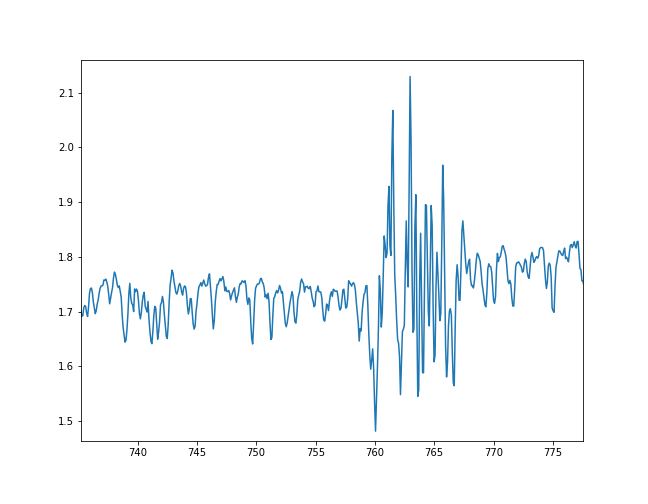

In [51]:
%matplotlib notebook
plt.plot(w, np.array(lunar/ycs[np.argmin(stds[n])+len(stds)*n]).astype(np.float32))

In [80]:
configsr = configs
# np.unique(configsr[i][:,2])

In [81]:
zdsr, pwvsr = np.unique(configsr[0][:,2]), np.unique(configsr[0][:,3])

In [82]:
# rhosr = rhos
# stdsr = stds
rhosr = rhos.reshape(len(zdsr),-1)
stdsr = stds.reshape(len(zdsr),-1)

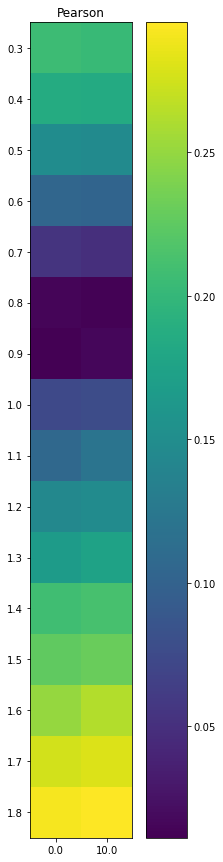

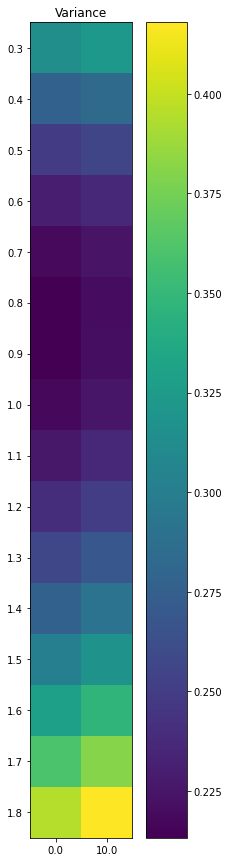

In [51]:
fig, ax = plt.subplots(figsize=(5, 15))

im = ax.imshow(np.abs(rhosr.T))
ax.set(title='Pearson')

ax.set_xticks(np.arange(len(zdsr)), labels=zdsr)
ax.set_yticks(np.arange(len(pwvsr)), labels=pwvsr);
plt.colorbar(im);

fig, ax = plt.subplots(figsize=(5, 15))

im = ax.imshow(stdsr.T**2*5000)
ax.set(title='Variance')

ax.set_xticks(np.arange(len(zdsr)), labels=zdsr)
ax.set_yticks(np.arange(len(pwvsr)), labels=pwvsr);
plt.colorbar(im);


In [54]:
np.argmin(stdsr)

5

In [58]:
stdsr[0,5]

0.006530293805236563

array([[ 0.20555882,  0.18636113,  0.14910942,  0.10487466,  0.05384429,
         0.01474299, -0.01107398, -0.07335686, -0.10700714, -0.14357912,
        -0.16746698, -0.20813823, -0.22616019, -0.25030143, -0.27615411,
        -0.29096822],
       [ 0.20220914,  0.1844001 ,  0.14730535,  0.10318405,  0.04944603,
         0.0125722 , -0.01586921, -0.07753175, -0.12080753, -0.14779527,
        -0.17437646, -0.21248509, -0.23060266, -0.26213974, -0.28058654,
        -0.2953204 ]])

In [ ]:
configsr[2]

In [ ]:
# for i in range(6):
#     sm, si, zdsr, pwvsr = configsr[i][0,0], configsr[i][0,1], configsr[i][:,2], configsr[i][:,3]
#     r = rhosr[i]
#     r = np.abs(r)
#     s = stdsr[i]
#     s = s**2*5000
#     plt.figure()
#     rmin = np.argmin(r)
#     plt.plot(pwvsr, r, label = '|Pearson correlation| in bands')
#     plt.vlines(pwvsr[rmin], r[rmin]-0.01, r[rmin]+0.01, 'k')
    
#     smin = np.argmin(s)
#     plt.plot(pwvsr, s, label = 'Variance in bands')
#     plt.vlines(pwvsr[smin], s[smin]-0.01, s[smin]+0.01, 'k')
#     plt.title(f'Smooth: {sm}, Sigma: {si}');
#     plt.xlabel('pwv')
#     plt.ylabel('pearson correlation/variance')
#     plt.legend();
#     print(np.argmin(s), np.argmin(r))

In [ ]:
rho5, rhos5, stds5 = [0.19416661221606513,
  0.1766931411748248,
  0.177882319970015,
  0.17710081951797285,
  0.17411324021276947,
  0.17197042447041172,
  0.1693576984513588,
  0.15842861614407505,
  0.13792186862438,
  0.11079234146506801,
  0.10286396861377926,
  0.0929922912951583,
  0.08033016223470489,
  0.06691314065125503,
  0.059070191578420646,
  0.04388924113118058,
  0.027501312184949698],[0.07108522165920735,
  0.04586409022383445,
  0.05165915447755638,
  0.05599220852035077,
  0.05724038639320505,
  0.06093674978391981,
  0.06347176302077269,
  0.05088594994906943,
  0.02588178866104426,
  -0.013576983265744174,
  -0.022755194349145504,
  -0.010682574302632185,
  -0.01785139778290904,
  -0.02511756870913929,
  -0.024840953160016232,
  -0.03366039683522697,
  -0.049993646892529615],[0.00911888490268169,
  0.008973634169594454,
  0.008846138430560554,
  0.008729669506501806,
  0.008621943968734112,
  0.0085265513161315,
  0.008439226691034944,
  0.008350730526039005,
  0.008270579457902872,
  0.008191400243135277,
  0.008125809868506214,
  0.00802659930775226,
  0.007933463221402058,
  0.007867062307546564,
  0.007823919493448881,
  0.007795633042200603,
  0.007782229266915778]

In [ ]:
rho1, rhos1, stds1 = [0.19416661221606513,
  0.1766931411748248,
  0.177882319970015,
  0.17710081951797285,
  0.17411324021276947,
  0.17197042447041172,
  0.1693576984513588,
  0.15842861614407505,
  0.13792186862438,
  0.11079234146506801,
  0.10286396861377926,
  0.0929922912951583,
  0.08033016223470489], [0.1894361517022494,
  0.16892867487546465,
  0.1700417523619299,
  0.16914613428363276,
  0.16565036807999733,
  0.16338597643967526,
  0.16060192378909005,
  0.14777475110088442,
  0.12462018773455287,
  0.093009402600456,
  0.08363341745127231,
  0.07448553038842746,
  0.060520437036788326],[0.00911888490268169,
  0.008973634169594454,
  0.008846138430560554,
  0.008729669506501806,
  0.008621943968734112,
  0.0085265513161315,
  0.008439226691034944,
  0.008350730526039005,
  0.008270579457902872,
  0.008191400243135277,
  0.008125809868506214,
  0.00802659930775226,
  0.007933463221402058]

In [ ]:
plt.plot(rho2, rho5)

In [ ]:
plt.plot(rhos2, rhos5)

In [ ]:
plt.plot(stds2, stds5)

In [ ]:
water_ranges

In [ ]:
# Here we try without the highpass filter

cut, kT = 0.12, 0.02
s = 0.2

zds = [0.0, 5.0, 10.0, 15.0, 20.0, 25, 30.0, 60.0, 75.0]
pwvs = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]

zds =[0.0]
# pwvs = [0.0, 0.5, 1.0, 2.0, 3.0, 5.0, 10.0]

sig = 0.2
rhos = []
fts = []
hs = []
ycs = []
smoothLunar = []

for i, r in enumerate(water_ranges):
    if i==0:
        w_mask = np.logical_and(w>r[0], w<r[1])
    else:
        m = np.logical_and(w>r[0], w<r[1])
        w_mask = np.logical_or(w_mask, m)
        
for zd in zds[:3]:
    fig, ax = plt.subplots(2, figsize = (20,12), sharex=True, gridspec_kw={'height_ratios':[2,1]})
    plt.subplots_adjust(hspace=.0)
    k=0
    for k, pwv in enumerate(pwvs):
        if k==0:
            k=0
#             ax[0].plot(w, lunar, label = 'Lunar observed')
        fname = f'transmission_zd{zd}_pwv{pwv}.dat'
        trans = pd.read_table(f'trans/{fname}', header=None, sep='\s+')
        trans.columns = ['wav', 'A']
        mask = np.logical_and(trans['wav']>min(w), trans['wav']<max(w))
        x, y = trans['wav'][mask], trans['A'][mask]
        yc = gconv(w, x, y, sig=sig)
        ycs.append(yc)
        lunarT = lunar/yc
#         lunarT, ft, fd = high_pass_fd(lunarT, cutoff = cut, kT = kT)
#         lunarT = np.sign(np.real(lunarT))*np.abs(lunarT) #dealing with complex numbers
        hs.append(lunarT)
        lunarsmooth = gconv(w, w, lunarT, sig = 0.3)

        lunarsmooth[~w_mask] = np.nan
        smoothLunar.append(lunarsmooth)
        rho = np.corrcoef(lunarT, yc)[0][1]
        
        ax[0].plot(w, lunarsmooth - s*k , label = f'Lunar corrected pwv; {pwv}, ZD: {zd}, rho: {rho:.3f}')

        ax[1].plot(w, yc, label=f'Transmission spectrum pwv; {pwv}, ZD: {zd}, Gaussian LSF(sigma={sig})')
        
       
        print(zd, pwv, rho)
        rhos.append(rho)
    ax[0].legend()
    ax[1].legend()
    xlims = ax[0].get_xlim()
    ax[0].set(xlim = (xlims[0]-100, xlims[1]))